In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/OCR

/content/drive/MyDrive/OCR


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import zipfile
from sklearn.model_selection import train_test_split


In [ ]:
zip_path = '/content/drive/MyDrive/OCR/Arabic-OCR-master-main.zip'
extract_path = '/content/char_4K_sample'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
!apt-get install unrar
!unrar x /content/char_4K_sample/Arabic-OCR-master-main/Dataset/char_4K_sample.rar /content/char_4K_sample/


Streaming output truncated to the last 5000 lines.
Extracting  /content/char_4K_sample/char_sample/و/4612.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4613.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4614.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4615.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4616.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4617.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4618.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4619.png                96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/462.png                 96%  OK 
Extracting  /content/char_4K_sample/char_sample/و/4620.png                96%  OK 
Extracting  /content/char_4K_

In [ ]:
X, y = [], []
data_dir = '/content/char_4K_sample/char_sample'

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (32, 32))
            X.append(img)
            y.append(label)

if len(X) == 0:
    raise ValueError("No images were successfully loaded.")

X = np.array(X).reshape(-1, 32, 32, 1) / 255.0
le = LabelEncoder()
y = le.fit_transform(y)
y = keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



In [ ]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(y.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('/content/best_ocr_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[checkpoint])
np.save('/content/arabic_ocr_labels.npy', le.classes_)

In [ ]:
model = keras.models.load_model('/content/best_ocr_model.h5')
le_classes = np.load('/content/arabic_ocr_labels.npy')
le = LabelEncoder()
le.classes_ = le_classes
loss, acc = model.evaluate(X_test, y_test)
np.save('/content/test_result.npy', np.array([loss, acc]))
from google.colab import files
files.download('/content/best_ocr_model.h5')
files.download('/content/arabic_ocr_labels.npy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image 1: Predicted: ظ, True: ظ


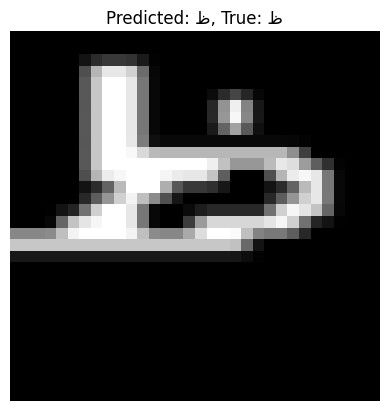

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 2: Predicted: ا, True: ا


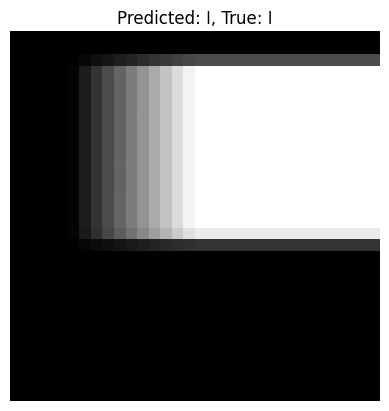

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image 3: Predicted: ص, True: ص


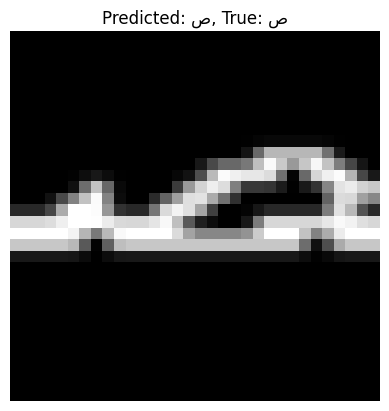

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 4: Predicted: ن, True: ن


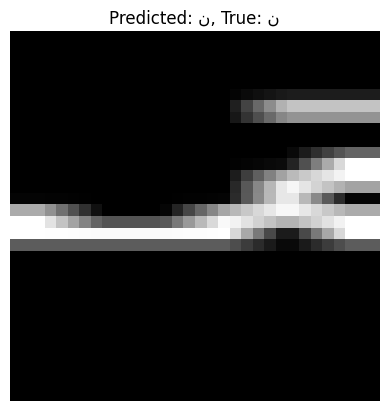

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image 5: Predicted: ذ, True: ذ


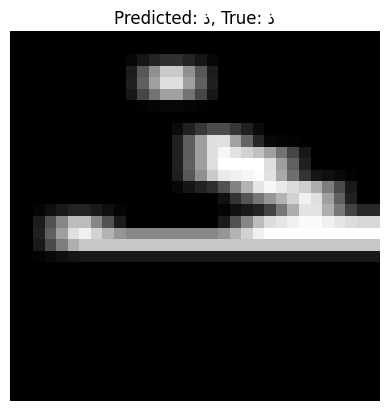

Accuracy: 100.00%


In [ ]:
num_images = 5
correct_predictions = 0

for i in range(num_images):
    img = X_test[i].reshape(32, 32)
    pred = model.predict(X_test[i:i+1])
    pred_label = le.inverse_transform([np.argmax(pred[0])])[0]
    true_label_index = np.argmax(y_test[i])
    true_label = le.inverse_transform([true_label_index])[0]

    print(f"Image {i + 1}: Predicted: {pred_label}, True: {true_label}")

    if pred_label == true_label:
        correct_predictions += 1

    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted: {pred_label}, True: {true_label}')
    plt.axis('off')
    plt.show()

accuracy = correct_predictions / num_images
print(f'Accuracy: {accuracy * 100:.2f}%')


In [ ]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f'Best model accuracy: {accuracy * 100:.2f}%')


Best model accuracy: 99.48%
